Sourse: https://python4mpia.github.io/fitting_data/least-squares-fitting.html

$\textbf{What is least squares?}$


- Minimise $\chi^2 = \sum_{n=1}^N \left(\frac{y_n - f(x_n)}{\sigma_n}\right)^2$
- If and only if the data’s noise is Gaussian, minimising $\chi^2$ is identical to maximising the likelihood $\mathcal L\propto e^{-\chi^2/2}$.
- If data’s noise model is unknown, then minimise $J(\theta) = \sum_{n=1}^N \left[(y_n - f(x_n;\theta)\right]^2$
- For non-Gaussian data noise, least squares is just a recipe (usually) without any probabilistic interpretation (no uncertainty estimates).

$\textbf{scipy.optimize.curve_fit}$

curve_fit is part of scipy.optimize and a wrapper for scipy.optimize.leastsq that overcomes its poor usability. Like leastsq, curve_fit internally uses a Levenburg-Marquardt gradient method (greedy algorithm) to minimise the objective function.

Let us create some toy data:

In [1]:
import numpy

# Generate artificial data = straight line with a=0 and b=1
# plus some noise.
xdata = numpy.array([0.0,1.0,2.0,3.0,4.0,5.0])
ydata = numpy.array([0.1,0.9,2.2,2.8,3.9,5.1])
# Initial guess.
x0    = numpy.array([0.0, 0.0, 0.0])

Data errors can also easily be provided:

In [2]:
sigma = numpy.array([1.0,1.0,1.0,1.0,1.0,1.0])

The objective function is easily (but less general) defined as the model:

In [3]:
def func(x, a, b, c):
    return a + b*x + c*x*x

Usage is very simple:

In [18]:
import scipy.optimize as optimization

print(optimization.curve_fit(func, xdata, ydata, x0, sigma))

(array([ 0.02857144, -0.99426929]), array([[0.01541497, 0.00211416],
       [0.00211416, 0.00042527]]))


This outputs the actual parameter estimate (a=0.1, b=0.88142857, c=0.02142857) and the 3x3 covariance matrix.

$\textbf{scipy.optimize.leastsq}$

Scipy provides a method called leastsq as part of its optimize package. However, there are tow problems:

+ This method is not well documented (no easy examples).
+ Error/covariance estimates on fit parameters not straight-forward to obtain.

Internally, leastsq uses Levenburg-Marquardt gradient method (greedy algorithm) to minimise the score function.

First step is to declare the objective function that should be minimised:

In [6]:
# The function whose square is to be minimised.
# params ... list of parameters tuned to minimise function.
# Further arguments:
# xdata ... design matrix for a linear model.
# ydata ... observed data.
def func(params, xdata, ydata):
    return (ydata - numpy.dot(xdata, params))

The toy data now needs to be provided in a more complex way:

In [9]:
# Provide data as design matrix: straight line with a=0 and b=1 plus some noise.
xdata = numpy.transpose(numpy.array([[1.0,1.0,1.0,1.0,1.0,1.0], [0.0,1.0,2.0,3.0,4.0,5.0]]))

$\textbf{Lack of robustness}$

Gradient methods such as Levenburg-Marquardt used by leastsq/curve_fit are greedy methods and simply run into the nearest local minimum.

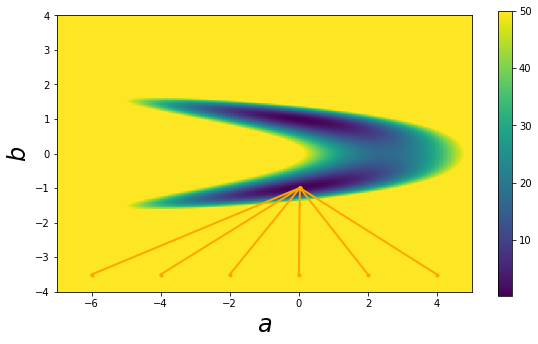

In [15]:
import numpy,math
import scipy.optimize as optimization
import matplotlib.pyplot as plt

# Chose a model that will create bimodality.
def func(x, a, b):
    return a + b*b*x  # Term b*b will create bimodality.

# Create toy data for curve_fit.
xdata = numpy.array([0.0,1.0,2.0,3.0,4.0,5.0])
ydata = numpy.array([0.1,0.9,2.2,2.8,3.9,5.1])
sigma = numpy.array([1.0,1.0,1.0,1.0,1.0,1.0])

# Compute chi-square manifold.
Steps = 101  # grid size
Chi2Manifold = numpy.zeros([Steps,Steps])  # allocate grid
amin = -7.0  # minimal value of a covered by grid
amax = +5.0  # maximal value of a covered by grid
bmin = -4.0  # minimal value of b covered by grid
bmax = +4.0  # maximal value of b covered by grid
for s1 in range(Steps):
    for s2 in range(Steps):
        # Current values of (a,b) at grid position (s1,s2).
        a = amin + (amax - amin)*float(s1)/(Steps-1)
        b = bmin + (bmax - bmin)*float(s2)/(Steps-1)
        # Evaluate chi-squared.
        chi2 = 0.0
        for n in range(len(xdata)):
            residual = (ydata[n] - func(xdata[n], a, b))/sigma[n]
            chi2 = chi2 + residual*residual
        Chi2Manifold[Steps-1-s2,s1] = chi2  # write result to grid.

# Plot grid.
plt.figure(1, figsize=(8,4.5))
plt.subplots_adjust(left=0.09, bottom=0.09, top=0.97, right=0.99)
# Plot chi-square manifold.
image = plt.imshow(Chi2Manifold, vmax=50.0,
              extent=[amin, amax, bmin, bmax])
# Plot where curve-fit is going to for a couple of initial guesses.
for a_initial in -6.0, -4.0, -2.0, 0.0, 2.0, 4.0:
    # Initial guess.
    x0   = numpy.array([a_initial, -3.5])
    xFit = optimization.curve_fit(func, xdata, ydata, x0, sigma)[0]
    plt.plot([x0[0], xFit[0]], [x0[1], xFit[1]], 'o-', ms=4,
                 markeredgewidth=0, lw=2, color='orange')
plt.colorbar(image)  # make colorbar
plt.xlim(amin, amax)
plt.ylim(bmin, bmax)
plt.xlabel(r'$a$', fontsize=24)
plt.ylabel(r'$b$', fontsize=24)
plt.savefig('demo-robustness-curve-fit.png')
plt.show()


# Second test

By $\href{https://machinelearningmastery.com/curve-fitting-with-python/}{Jason Brownlee}$

Curve fitting is a type of optimization that finds an optimal set of parameters for a defined function that best fits a given set of observations.

Unlike supervised learning, curve fitting requires that you define the function that maps examples of inputs to outputs.

The mapping function, also called the basis function can have any form you like, including a straight line (linear regression), a curved line (polynomial regression), and much more. This provides the flexibility and control to define the form of the curve, where an optimization process is used to find the specific optimal parameters of the function.

In this tutorial, you will discover how to perform curve fitting in Python.

After completing this tutorial, you will know:

- Curve fitting involves finding the optimal parameters to a function that maps examples of inputs to outputs.
- The SciPy Python library provides an API to fit a curve to a dataset.
- How to use curve fitting in SciPy to fit a range of different curves to a set of observations.

Let’s get started.

$\textbf{Curve Fitting}$

Curve fitting is an optimization problem that finds a line that best fits a collection of observations.

It is easiest to think about curve fitting in two dimensions, such as a graph.

Consider that we have collected examples of data from the problem domain with inputs and outputs.

The x-axis is the independent variable or the input to the function. The y-axis is the dependent variable or the output of the function. We don’t know the form of the function that maps examples of inputs to outputs, but we suspect that we can approximate the function with a standard function form.

Curve fitting involves first defining the functional form of the mapping function (also called the basis function or objective function), then searching for the parameters to the function that result in the minimum error.

Error is calculated by using the observations from the domain and passing the inputs to our candidate mapping function and calculating the output, then comparing the calculated output to the observed output.

Once fit, we can use the mapping function to interpolate or extrapolate new points in the domain. It is common to run a sequence of input values through the mapping function to calculate a sequence of outputs, then create a line plot of the result to show how output varies with input and how well the line fits the observed points.

The key to curve fitting is the form of the mapping function.

A straight line between inputs and outputs can be defined as follows:

       y = a * x + b

Where y is the calculated output, x is the input, and a and b are parameters of the mapping function found using an optimization algorithm.

This is called a linear equation because it is a weighted sum of the inputs.

In a linear regression model, these parameters are referred to as coefficients; in a neural network, they are referred to as weights.

This equation can be generalized to any number of inputs, meaning that the notion of curve fitting is not limited to two-dimensions (one input and one output), but could have many input variables.

For example, a line mapping function for two input variables may look as follows:

    y = a1 * x1 + a2 * x2 + b

The equation does not have to be a straight line.

We can add curves in the mapping function by adding exponents. For example, we can add a squared version of the input weighted by another parameter:

    y = a * x + b * x^2 + c

This is called polynomial regression, and the squared term means it is a second-degree polynomial.

So far, linear equations of this type can be fit by minimizing least squares and can be calculated analytically. This means we can find the optimal values of the parameters using a little linear algebra.

We might also want to add other mathematical functions to the equation, such as sine, cosine, and more. Each term is weighted with a parameter and added to the whole to give the output; for example:

    y = a * sin(b * x) + c

Adding arbitrary mathematical functions to our mapping function generally means we cannot calculate the parameters analytically, and instead, we will need to use an iterative optimization algorithm.

This is called nonlinear least squares, as the objective function is no longer convex (it’s nonlinear) and not as easy to solve.

Now that we are familiar with curve fitting, let’s look at how we might perform curve fitting in Python.

$\textbf{Curve Fitting Python API}$

We can perform curve fitting for our dataset in Python.

The SciPy open source library provides the $\href{https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html}{curve_fit()}$ function for curve fitting via nonlinear least squares.

The function takes the same input and output data as arguments, as well as the name of the mapping function to use.

The mapping function must take examples of input data and some number of arguments. These remaining arguments will be the coefficients or weight constants that will be optimized by a nonlinear least squares optimization process.

For example, we may have some observations from our domain loaded as input variables x and output variables y.

Next, we need to design a mapping function to fit a line to the data and implement it as a Python function that takes inputs and the arguments.

It may be a straight line, in which case it would look as follows:

We can then call the curve_fit() function to fit a straight line to the dataset using our defined function.

The function curve_fit() returns the optimal values for the mapping function, e.g, the coefficient values. It also returns a covariance matrix for the estimated parameters, but we can ignore that for now.

Once fit, we can use the optimal parameters and our mapping function objective() to calculate the output for any arbitrary input.

This might include the output for the examples we have already collected from the domain, it might include new values that interpolate observed values, or it might include extrapolated values outside of the limits of what was observed.

Now that we are familiar with using the curve fitting API, let’s look at a worked example.

$\textbf{Curve Fitting Worked Example}$

We will develop a curve to fit some real world observations of economic data.

In this example, we will use the so-called “Longley’s Economic Regression” dataset; you can learn more about it here:

- Longley’s Economic Regression (longley.csv)
- Longley’s Economic Regression Description (longley.names)

We will download the dataset automatically as part of the worked example.

There are seven input variables and 16 rows of data, where each row defines a summary of economic details for a year between 1947 to 1962.

In this example, we will explore fitting a line between population size and the number of people employed for each year.

The example below loads the dataset from the URL, selects the input variable as $"\textit{population}"$ and the output variable as $“\textit{employed}”$ and creates a scatter plot.

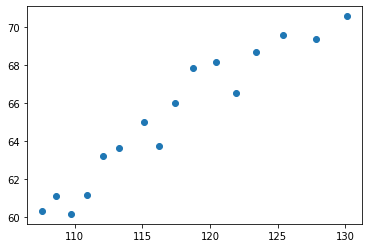

<Figure size 1440x1440 with 0 Axes>

In [43]:
# plot "Population" vs "Employed"
from pandas import read_csv
from matplotlib import pyplot
import numpy as np
# load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/longley.csv'
dataframe = read_csv(url, header=None)
data = dataframe.values
# choose the input and output variables
x, y = data[:, 4], data[:, -1]
# plot input vs output
pyplot.scatter(x, y)
pyplot.figure(figsize=(20,20))
pyplot.show()

Running the example loads the dataset, selects the variables, and creates a scatter plot.

We can see that there is a relationship between the two variables. Specifically, that as the population increases, the total number of employees increases.

It is not unreasonable to think we can fit a line to this data.

First, we will try fitting a straight line to this data, as follows:

In [44]:
# define the true objective function
def objective(x, a, b):
    return a * x + b

We can use curve fitting to find the optimal values of “a” and “b” and summarize the values that were found:

In [45]:
# curve fit
popt, _ = curve_fit(objective, x, y)
# summarize the parameter values
a, b = popt
print('y = %.5f * x + %.5f' % (a, b))

y = 0.48488 * x + 8.38067


We can then create a scatter plot as before.

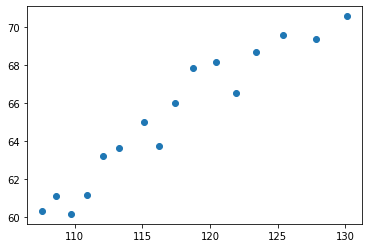

In [46]:
# plot input vs output
pyplot.scatter(x, y)

On top of the scatter plot, we can draw a line for the function with the optimized parameter values.

This involves first defining a sequence of input values between the minimum and maximum values observed in the dataset (e.g. between about 120 and about 130).

In [48]:
# define a sequence of inputs between the smallest and largest known inputs
x_line = np.arange(min(x), max(x), 1)

We can then calculate the output value for each input value.

In [49]:
# calculate the output for the range
y_line = objective(x_line, a, b)

Then create a line plot of the inputs vs. the outputs to see a line:

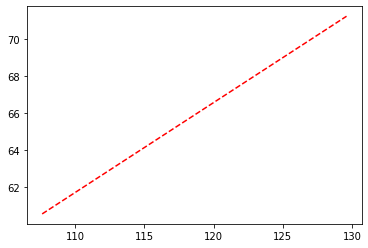

In [50]:
# create a line plot for the mapping function
pyplot.plot(x_line, y_line, '--', color='red')

Tying this together, the example below uses curve fitting to find the parameters of a straight line for our economic data.

All together:

y = 0.48488 * x + 8.38067
We can see that it is a reasonably good fit.


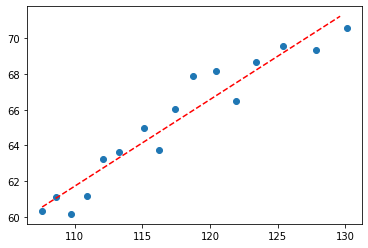

In [57]:
# fit a straight line to the economic data
from numpy import arange
from pandas import read_csv
from scipy.optimize import curve_fit
from matplotlib import pyplot
 
# define the true objective function
def objective(x, a, b):
    return a * x + b
 
# load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/longley.csv'
dataframe = read_csv(url, header=None)
data = dataframe.values
# choose the input and output variables
x, y = data[:, 4], data[:, -1]
# curve fit
popt, _ = curve_fit(objective, x, y)
# summarize the parameter values
a, b = popt
print('y = %.5f * x + %.5f' % (a, b))
print('We can see that it is a reasonably good fit.')
# plot input vs output
pyplot.scatter(x, y)
# define a sequence of inputs between the smallest and largest known inputs
x_line = arange(min(x), max(x), 1)
# calculate the output for the range
y_line = objective(x_line, a, b)
# create a line plot for the mapping function
pyplot.plot(x_line, y_line, '--', color='red')
pyplot.show()

So far, this is not very exciting as we could achieve the same effect by fitting a linear regression model on the dataset.

Let’s try a polynomial regression model by adding squared terms to the objective function.

In [58]:
# define the true objective function
def objective(x, a, b, c):
    return a * x + b * x**2 + c

Tying this together, the complete example is listed below.

y = 3.25443 * x + -0.01170 * x^2 + -155.02783


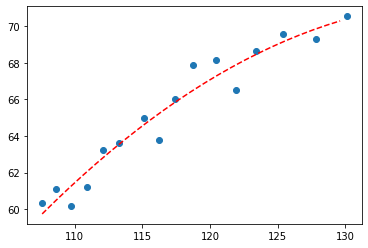

In [56]:
# fit a second degree polynomial to the economic data
from numpy import arange
from pandas import read_csv
from scipy.optimize import curve_fit
from matplotlib import pyplot
 
# define the true objective function
def objective(x, a, b, c):
    return a * x + b * x**2 + c
 
# load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/longley.csv'
dataframe = read_csv(url, header=None)
data = dataframe.values
# choose the input and output variables
x, y = data[:, 4], data[:, -1]
# curve fit
popt, _ = curve_fit(objective, x, y)
# summarize the parameter values
a, b, c = popt
print('y = %.5f * x + %.5f * x^2 + %.5f' % (a, b, c))
# plot input vs output
pyplot.scatter(x, y)
# define a sequence of inputs between the smallest and largest known inputs
x_line = arange(min(x), max(x), 1)
# calculate the output for the range
y_line = objective(x_line, a, b, c)
# create a line plot for the mapping function
pyplot.plot(x_line, y_line, '--', color='red')
pyplot.show()

First the optimal parameters are reported.

We can see that the second-degree polynomial equation that we defined is visually a better fit for the data than the straight line that we tested first.

We could keep going and add more polynomial terms to the equation to better fit the curve.

For example, below is an example of a fifth-degree polynomial fit to the data.

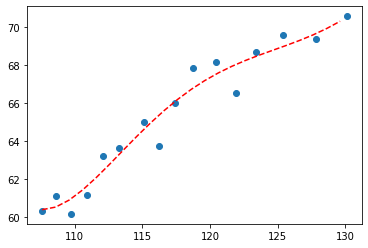

In [62]:
# fit a fifth degree polynomial to the economic data
from numpy import arange
from pandas import read_csv
from scipy.optimize import curve_fit
from matplotlib import pyplot
 
# define the true objective function
def objective(x, a, b, c, d, e, f):
    return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + f
 
# load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/longley.csv'
dataframe = read_csv(url, header=None)
data = dataframe.values
# choose the input and output variables
x, y = data[:, 4], data[:, -1]
# curve fit
popt, _ = curve_fit(objective, x, y)
# summarize the parameter values
a, b, c, d, e, f = popt
# plot input vs output
pyplot.scatter(x, y)
# define a sequence of inputs between the smallest and largest known inputs
x_line = arange(min(x), max(x), 1)
# calculate the output for the range
y_line = objective(x_line, a, b, c, d, e, f)
# create a line plot for the mapping function
pyplot.plot(x_line, y_line, '--', color='red')
pyplot.show()

Importantly, we are not limited to linear regression or polynomial regression. We can use any arbitrary basis function.

For example, perhaps we want a line that has wiggles to capture the short-term movement in observation. We could add a sine curve to the equation and find the parameters that best integrate this element in the equation.

For example, an arbitrary function that uses a sine wave and a second degree polynomial is listed below:

In [64]:
# define the true objective function
def objective(x, a, b, c, d):
    return a * sin(b - x) + c * x**2 + d

The complete example of fitting a curve using this basis function is listed below.

[8.83095636e-01 1.48622924e+00 2.05997116e-03 3.69046168e+01]


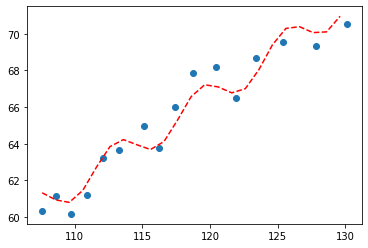

In [66]:
# fit a line to the economic data
from numpy import sin
from numpy import sqrt
from numpy import arange
from pandas import read_csv
from scipy.optimize import curve_fit
from matplotlib import pyplot
 
# define the true objective function
def objective(x, a, b, c, d):
    return a * sin(b - x) + c * x**2 + d
 
# load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/longley.csv'
dataframe = read_csv(url, header=None)
data = dataframe.values
# choose the input and output variables
x, y = data[:, 4], data[:, -1]
# curve fit
popt, _ = curve_fit(objective, x, y)
# summarize the parameter values
a, b, c, d = popt
print(popt)
# plot input vs output
pyplot.scatter(x, y)
# define a sequence of inputs between the smallest and largest known inputs
x_line = arange(min(x), max(x), 1)
# calculate the output for the range
y_line = objective(x_line, a, b, c, d)
# create a line plot for the mapping function
pyplot.plot(x_line, y_line, '--', color='red')
pyplot.show()

$\textbf{How do you choose the best fit?}$

If you want the best fit, you would model the problem as a regression supervised learning problem and test a suite of algorithms in order to discover which is best at minimizing the error.

In this case, curve fitting is appropriate when you want to define the function explicitly, then discover the parameters of your function that best fit a line to the data.